In [1]:
!pip install import_ipynb
!pip install seaborn
!pip install torch
!pip install mne
!pip install braindecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 4.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 45.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 32.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 5.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 35.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 KB 3.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 KB 2.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 42.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 KB 4.8 MB/s eta 0:00:00a 0:00:01


In [51]:
import import_ipynb
import numpy as np
from PreProcessing_v1 import import_tuh_abnormal
from DataTransform import data_transform, train_valid_test_split, get_parameters_for_model
# from TrainingValidationTesting import *
import torch
from braindecode.preprocessing import preprocess, Preprocessor, scale as multiply
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet, Deep4Net
from torch import optim
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns

# Importing TUH Abnormal dataset

In [94]:
TUH_PATH = 'TUH EEG Abnormal dataset/Abnormal/' # specify the path to the TUH Abnormal dataset
N_JOBS = 40  # specify the number of jobs for loading and windowing

# parameters to be defined for the preprocessing pipeline
TMIN = 1 * 60
TMAX = 5 * 60 
SFREQ = 100
CLIPPING = 800


In [95]:
tuh_abnormal = import_tuh_abnormal(TUH_PATH, N_JOBS)

# Preprocessing

In [96]:
def create_ch_mapping():
    short_ch_names = sorted([
        'A1', 'A2',
        'FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
        'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ'])
    ar_ch_names = sorted([
        'EEG A1-REF', 'EEG A2-REF',
        'EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF',
        'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF',
        'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF',
        'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF'])
    le_ch_names = sorted([
        'EEG A1-LE', 'EEG A2-LE',
        'EEG FP1-LE', 'EEG FP2-LE', 'EEG F3-LE', 'EEG F4-LE', 'EEG C3-LE',
        'EEG C4-LE', 'EEG P3-LE', 'EEG P4-LE', 'EEG O1-LE', 'EEG O2-LE',
        'EEG F7-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG T4-LE', 'EEG T5-LE',
        'EEG T6-LE', 'EEG FZ-LE', 'EEG CZ-LE', 'EEG PZ-LE'])
    assert len(short_ch_names) == len(ar_ch_names) == len(le_ch_names)
    ar_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
        ar_ch_names, short_ch_names)}
    le_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
        le_ch_names, short_ch_names)}
    ch_mapping = {'ar': ar_ch_mapping, 'le': le_ch_mapping}    
    return short_ch_names, ch_mapping


def select_by_channels(ds, short_ch_names, ch_mapping):
    split_ids = []
    for i, d in enumerate(ds.datasets):
        ref = 'ar' if d.raw.ch_names[0].endswith('-REF') else 'le'
        # these are the channels we are looking for
        seta = set(ch_mapping[ref].keys())
        # these are the channels of the recoding
        setb = set(d.raw.ch_names)
        # if recording contains all channels we are looking for, include it
        if seta.issubset(setb):
            split_ids.append(i)
    return ds.split(split_ids)['0']


def custom_crop(raw, tmin=0.0, tmax=None, include_tmax=True):
    # crop recordings to tmin – tmax. can be incomplete if recording
    # has lower duration than tmax
    # by default mne fails if tmax is bigger than duration
    tmax = min((raw.n_times - 1) / raw.info['sfreq'], tmax)
    raw.crop(tmin=tmin, tmax=tmax, include_tmax=include_tmax)
    
    
def custom_rename_channels(raw, mapping):
    # rename channels which are dependent on referencing:
    # le: EEG 01-LE, ar: EEG 01-REF
    # mne fails if the mapping contains channels as keys that are not present
    # in the raw
    reference = raw.ch_names[0].split('-')[-1].lower()
    assert reference in ['le', 'ref'], 'unexpected referencing'
    reference = 'le' if reference == 'le' else 'ar'
    raw.rename_channels(mapping[reference])
    
short_ch_names, ch_mapping = create_ch_mapping()

preprocessors = [
        Preprocessor(custom_crop, tmin=TMIN, tmax=TMAX, include_tmax=True,
                     apply_on_array=False),
        Preprocessor('set_eeg_reference', ref_channels='average', ch_type='eeg'), # mne Raw class function
        Preprocessor(custom_rename_channels, mapping=ch_mapping, # rename channels to short channel names
                     apply_on_array=False), #
        Preprocessor('pick_channels', ch_names=short_ch_names, ordered=True), # mne Raw class function
        Preprocessor(multiply, factor=1e6, apply_on_array=True), # scaling signals to microvolt
        Preprocessor(np.clip, a_min=-CLIPPING, a_max=CLIPPING, apply_on_array=True), # clip outlier values to +/- 800 micro volts
        Preprocessor('resample', sfreq=SFREQ), # mne Raw class function
    ]

In [ ]:
tuh_preproc = preprocess(
        concat_ds=tuh_abnormal,
        preprocessors=preprocessors,
        n_jobs=N_JOBS,
        save_dir=None
    )

# Data Transform

In [12]:
import matplotlib.pyplot as plt
from braindecode.datasets.tuh import TUHAbnormal, TUH
from braindecode.models import get_output_shape
from braindecode.preprocessing import create_fixed_length_windows
from torch.utils.data import DataLoader
from DataTransform import data_transform, train_valid_test_split, get_parameters_for_model

In [ ]:
tuh_train, tuh_val, tuh_test = train_valid_test_split(tuh_preproc, train_size=0.9)

In [ ]:
len(tuh_train.datasets)

In [ ]:
# Extract number of chans and time steps from dataset
in_chans, input_size_samples = get_parameters_for_model(tuh_train)

print(in_chans, input_size_samples)

In [ ]:
TRAIN_SIZE=0.9
INPUT_WIN_SAMPLES = 6000
BATCH_SIZE=64

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 2


model = Deep4Net(
    in_chans,
    n_classes,
    input_window_samples=INPUT_WIN_SAMPLES,
    final_conv_length=1,
)


# Send model to GPU
if cuda:
    model.to(device)
    

train_loader, val_loader, test_loader = data_transform(tuh_train, tuh_val, tuh_test, model, train_size=TRAIN_SIZE, batch_size=BATCH_SIZE, input_window_samples=INPUT_WIN_SAMPLES, in_chans = in_chans)

In [ ]:
len(train_loader)

# Training and testing

In [26]:
from TrainingValidationTesting import train_model, validate_model, test_model

importing Jupyter notebook from TrainingValidationTesting.ipynb


In [82]:
# hyperparameters for training the model
lr =  0.01
optimizer = optim.Adam(params=model.parameters(), lr=lr)
criterion = torch.nn.NLLLoss()
batch_size = 64
n_epochs = 35  
patience = 10

# Using multiple GPUs
model = torch.nn.DataParallel(model)

In [83]:

trained_model, train_losses, valid_losses = train_model(model, device, criterion, optimizer, train_loader, val_loader, n_epochs, patience)

Time: 05/03/2022, 19:57:01. . [1/35, 169/3361] train_loss: 0.810026, train_acc: 0.613
Time: 05/03/2022, 19:57:15. . [1/35, 338/3361] train_loss: 0.721747, train_acc: 0.644
Time: 05/03/2022, 19:57:29. . [1/35, 507/3361] train_loss: 0.68607, train_acc: 0.657
Time: 05/03/2022, 19:57:42. . [1/35, 676/3361] train_loss: 0.668554, train_acc: 0.666
Time: 05/03/2022, 19:57:56. . [1/35, 845/3361] train_loss: 0.660074, train_acc: 0.671
Time: 05/03/2022, 19:58:09. . [1/35, 1014/3361] train_loss: 0.652637, train_acc: 0.675
Time: 05/03/2022, 19:58:23. . [1/35, 1183/3361] train_loss: 0.647273, train_acc: 0.678
Time: 05/03/2022, 19:58:38. . [1/35, 1352/3361] train_loss: 0.643488, train_acc: 0.68
Time: 05/03/2022, 19:58:52. . [1/35, 1521/3361] train_loss: 0.639924, train_acc: 0.682
Time: 05/03/2022, 19:59:06. . [1/35, 1690/3361] train_loss: 0.637025, train_acc: 0.684
Time: 05/03/2022, 19:59:20. . [1/35, 1859/3361] train_loss: 0.634777, train_acc: 0.685
Time: 05/03/2022, 19:59:36. . [1/35, 2028/3361] tr

In [84]:
trained_model.to(device)

DataParallel(
  (module): Deep4Net(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 25, kernel_size=(10, 1), stride=(1, 1))
    (conv_spat): Conv2d(25, 25, kernel_size=(1, 21), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin): Expression(expression=elu) 
    (pool): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
    (pool_nonlin): Expression(expression=identity) 
    (drop_2): Dropout(p=0.5, inplace=False)
    (conv_2): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), bias=False)
    (bnorm_2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin_2): Expression(expression=elu) 
    (pool_2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
    (pool_nonlin_2): Expression(expression=identity) 
    (drop_3): Dropout

In [38]:
from TrainingValidationTesting_1 import test_model

importing Jupyter notebook from TrainingValidationTesting_1.ipynb


In [85]:
y_true, y_pred = test_model(device, trained_model, test_loader)

Accuracy: 0.77
Accuracy2: 0.77


In [86]:
# Save the trained model

PATH = './cnndeep2min.pth'
torch.save(model.state_dict(), PATH)

#how to reload the saved model:
'''
model = Deep4Net(
    in_chans,
    n_classes,
    input_window_samples=INPUT_WIN_SAMPLES,
    final_conv_length=1,
)
model.load_state_dict(torch.load(PATH))
'''

'\nmodel = Deep4Net(\n    in_chans,\n    n_classes,\n    input_window_samples=INPUT_WIN_SAMPLES,\n    final_conv_length=1,\n)\nmodel.load_state_dict(torch.load(PATH))\n'

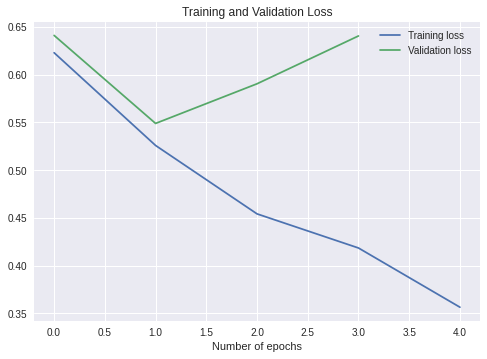

In [87]:
# Losses plot

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Number of epochs')
plt.legend(frameon=False)
plt.show()

In [90]:
# Confusion matrix and Classification Report

y_true = y_true.cpu()
y_pred = y_pred.cpu()

conf_matrix = confusion_matrix(y_true.flatten(), y_pred.flatten())
cl_report = classification_report(y_true.flatten(), y_pred.flatten())

In [91]:
print(cl_report)

              precision    recall  f1-score   support

         0.0       0.74      0.87      0.80    910800
         1.0       0.80      0.65      0.72    765072

    accuracy                           0.77   1675872
   macro avg       0.77      0.76      0.76   1675872
weighted avg       0.77      0.77      0.76   1675872



In [61]:
y_true.numpy()
y_pred.numpy()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)

In [62]:
roc_auc_score = roc_auc_score(y_true, y_pred)
roc_auc_score

TypeError: 'numpy.float64' object is not callable

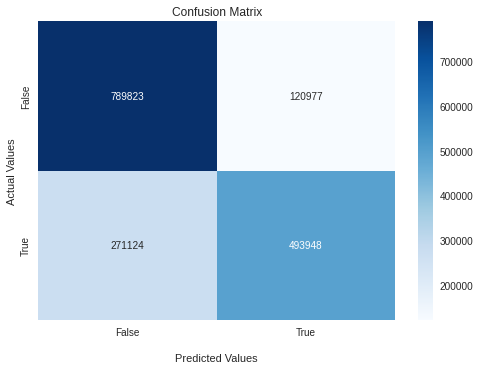

In [92]:
# Confusion matrix with numbers

ax = sns.heatmap(conf_matrix, annot=True,  fmt = 'd', cmap='Blues')
ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

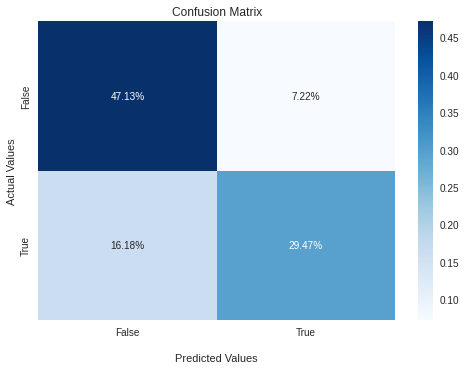

In [93]:
# Confusion matrix with %

ax1 = sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues')
ax1.set_title('Confusion Matrix');
ax1.set_xlabel('\nPredicted Values')
ax1.set_ylabel('Actual Values');

## Ticket labels - List must be in alphabetical order
ax1.xaxis.set_ticklabels(['False','True'])
ax1.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()